### NOTICE:
1. remember that this is only a sample copied form kaggle kernal, [the original scripit is here](https://www.kaggle.com/guyko81/allstate-claims-severity/just-an-easy-solution/comments)
2. having problem with install xgboost packages? [link](https://github.com/dmlc/xgboost/tree/master/python-package)


In [1]:
import xgboost as xgb 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import norm, lognorm, probplot
import matplotlib.mlab as mlab
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None) #display all columns
%matplotlib inline

In [4]:
#read the data
train = pd.read_csv("/Users/yangyang/Desktop/BIA652C/final proj/train.csv")
test = pd.read_csv("/Users/yangyang/Desktop/BIA652C/final proj/test.csv")

In [5]:
#Check the null value in train data
print("Number of missing values in train:",train.isnull().sum().sum())

Number of missing values in train: 0


In [6]:
#Check the null value in test data
print("Number of missing values in test:",test.isnull().sum().sum())

Number of missing values in test: 0


In [7]:
#define the features of train data
features = [x for x in train.columns if x not in ['id','loss']]
cat_features = [x for x in train.columns if 'cat' in x]
num_features = [x for x in train.columns if 'cont' in x]

print('train size is {}, test size is {}'.format(train.shape,test.shape) )

train size is (188318, 132), test size is (125546, 131)


- Analyze the continue data in train

In [8]:
#check the skewness of continues data
print(train.skew())

id       -0.002155
cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
loss      3.794958
dtype: float64


- we can read from the result that data in loss is highly skewed

In [9]:
#read the statistic description
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


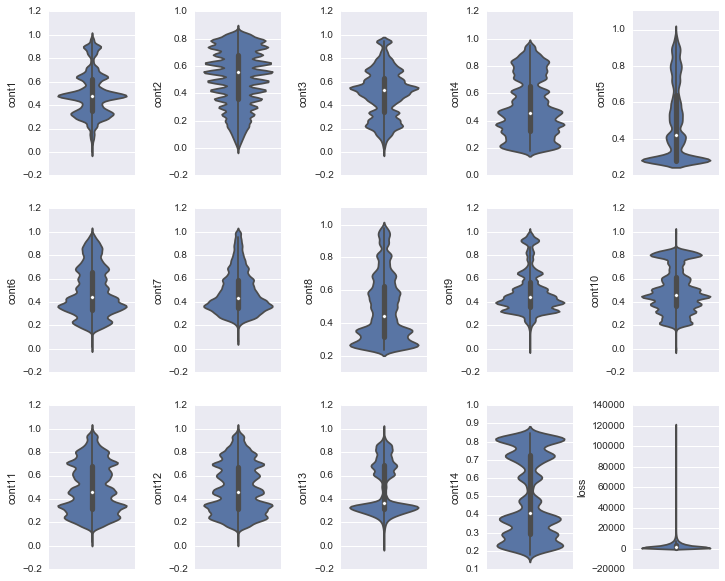

In [10]:
# draw the seaborn.violinplot
violin_data = pd.concat((train[num_features],train['loss']),axis=1)
names = violin_data.columns

fig_num,ax=plt.subplots(nrows=3,ncols=5,figsize=(12,10))
plt.subplots_adjust(wspace=0.7)
for row in range(3):
    for col in range(5):
        sns.violinplot(y=names[row*5+col],data = violin_data,ax=ax[row,col])


In [11]:
# use stats.shapiro to see whether the distribution is normal
shapiro_stats = []
for i in range(len(num_features)):
    shapiro_stat =  shapiro(train[num_features].iloc[:,i])[1]
    shapiro_stats.append(shapiro_stat)
print(shapiro_stats)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


- none of features follow normal distribution

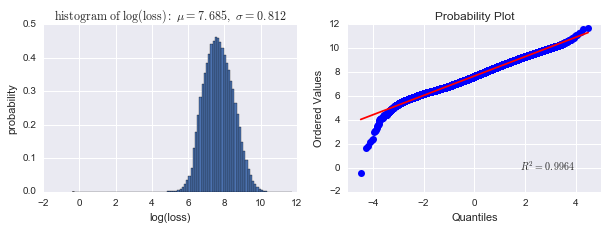

In [12]:
#check whether the loss follows a log-normal distribution
train['log_loss'] = np.log(train['loss']) # https://www.zhihu.com/question/22012482
f,(fig1,fig2) = plt.subplots(1,2,figsize = (10,3))
fig1.hist(np.log(train['loss']),bins=100,normed = 1)
fig1.set_xlabel('log(loss)')
fig1.set_ylabel('probability')
(mu , sigma) = norm.fit(train['log_loss'])
fig1.set_title(r'$\mathrm{histogram\ of\ log(loss):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

probplot(np.log(train['loss']),plot=fig2)

plt.show()

- So we got normal distribution by applying logarithm on loss function

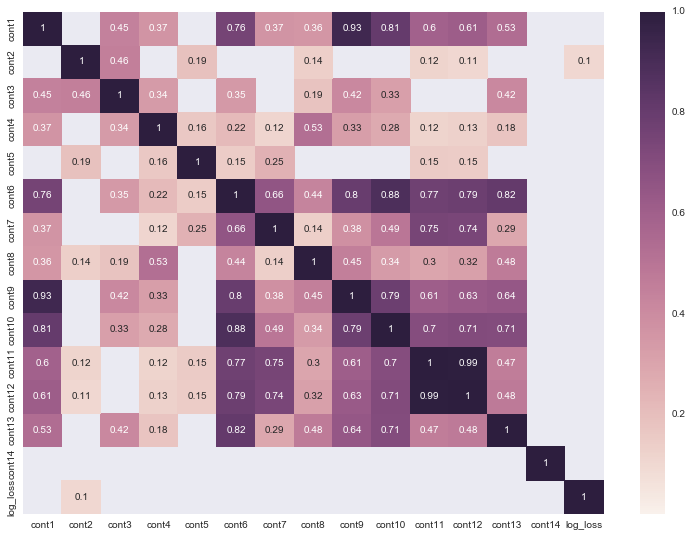

In [24]:
#a different heatmap choose a beatiful one
correlationMatrix = pd.concat((train[num_features],train['log_loss']),axis=1).corr().abs()

plt.subplots(figsize=(13, 9))
sns.heatmap(correlationMatrix,mask=correlationMatrix < 0.1,annot=True)



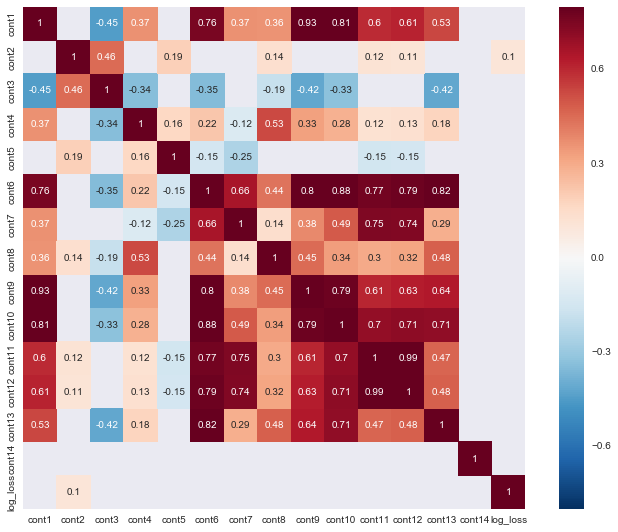

In [28]:
#Correlation between continuous features
cor_mat_data = pd.concat((train[num_features],train['log_loss']),axis=1)
fig,ax = plt.subplots(figsize=(12,9))
sns.heatmap(cor_mat_data.corr(),vmax=.8, mask=abs(correlationMatrix) < 0.1 ,square=True,annot=True)

### Some of the continuous features are quite correlated, which makes it hard to count on linear regressions right away

- Analyze the categorical data in train

In [63]:
#read the first 5th cat_features
cat_features[:5]

['cat1', 'cat2', 'cat3', 'cat4', 'cat5']

In [64]:
#read the last 5th cat_features
cat_features[-5:]

['cat112', 'cat113', 'cat114', 'cat115', 'cat116']

In [65]:
#read the number of types of categorical data in each cat_feature
uniq_var = []
for i in cat_features:
    uniq_var.append(len(set(train[i])))
print(uniq_var)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 7, 8, 7, 5, 7, 5, 8, 7, 5, 16, 15, 19, 9, 13, 17, 20, 17, 20, 11, 84, 131, 16, 51, 61, 19, 23, 326]


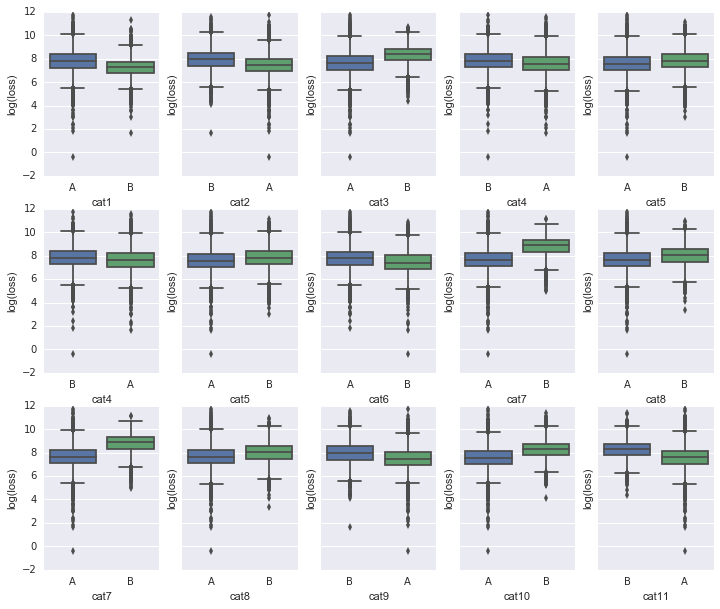

In [66]:
#boxplot for each cat_feature
train['log(loss)'] = np.log(train['loss'])
fig_cat_top15,ax = plt.subplots(nrows=3,ncols=5,figsize=(12,10),sharey=True)
for row in range(3):
    for col in range(5):
        sns.boxplot(train[cat_features[row*3+col]],train['log(loss)'],ax=ax[row,col])
        

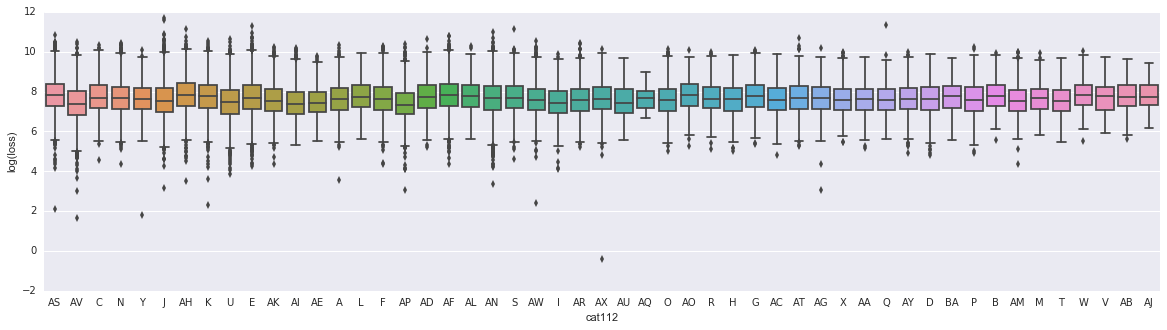

In [67]:
#boxplot for each type of categorical data
# satets boxplot(having 51 variables)
plt.rc('figure',figsize=(20,5))
sns.boxplot(train[cat_features[-5]],train['log(loss)'])

In [54]:
# transfrom from cat to num variables
# for i in range(len(cat_features)):
#    train_test[cat_features[i]] = train_test[cat_features[i]].astype('category').cat.codes


In [68]:
train_test = pd.concat((train[features],test[features]),axis=0).reset_index(drop=1)

train_test_cat_encoded =pd.get_dummies(train_test[cat_features])

In [69]:
train_test_cat_encoded.shape

(313864, 1176)

In [70]:
# seperate our data into test & train  again
train_test_encoded = pd.concat((train_test_cat_encoded,train_test[num_features]),axis=1)

train_x = train_test_encoded.iloc[:nrow_train,:]
test_x = train_test_encoded.iloc[nrow_train:,:]

NameError: name 'nrow_train' is not defined

In [ ]:
train_x.head()

- build up the xgboost model

In [ ]:
xgbmat = xgb.DMatrix(train_x,train['log_loss'])

params = {'eta': 0.01, 'seed':0, 'subsample': 0.5, 'colsample_bytree': 0.5, 
             'objective': 'reg:linear', 'max_depth':6, 'min_child_weight':3}

num_rounds = 2000

bst = xgb.train(params,xgbmat,num_rounds)
pred = bst.predict(xgb.DMatrix(test_x))

In [ ]:
loss = pd.DataFrame(np.e**pred)
id = test['id']
rslt = pd.DataFrame({'id':test['id'],'loss':np.e**pred})

In [ ]:
rslt

In [ ]:
rslt.to_csv('result3_2000run_encoded4cats.csv',index=0)

- following is a little example using get_dummies to do one hot enc

In [ ]:
tst = np.transpose(pd.DataFrame([['A','B','B'],['A','B','C']]))
tst

In [ ]:
pd.get_dummies(tst)